# Example prediction on a single test image

This notebook gives example code to make a single disparity prediction for one test image.

The file `test_simple.py` shows a more complete version of this code, which additionally:
- Can run on GPU or CPU (this notebook only runs on CPU)
- Can predict for a whole folder of images, not just a single image
- Saves predictions to `.npy` files and disparity images.

In [1]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
import networks
from utils import download_model_if_doesnt_exist

/opt/conda/lib/python3.6/site-packages/torchvision/io/_video_opt.py:17: UserWarning: video reader based on ffmpeg c++ ops not available
  warnings.warn("video reader based on ffmpeg c++ ops not available")


## Setting up network and loading weights

In [2]:
model_name = "mono_640x192"

download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval();

## Loading the test image and preprocessing

In [3]:
image_path = "assets/test_image.jpg"

input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

## Prediction using the PyTorch model

In [4]:
with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]

## Plotting

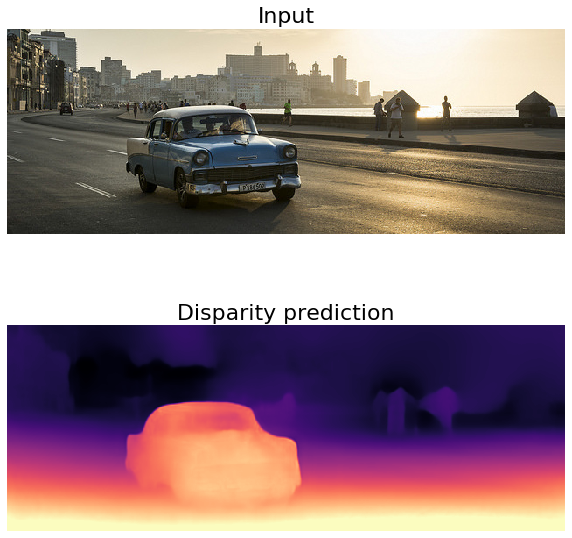

In [5]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');

In [6]:
from torch.utils.data import DataLoader
import datasets

In [9]:
fpath = os.path.join("./splits", "eigen_zhou", "{}_files.txt")

In [25]:
with open(fpath.format("train"), 'r') as f:
    train_filenames = f.read().splitlines()
data_path = "/work/garin0115/datasets/KITTI/"
batch_size = 8
num_workers = 4
img_ext = ".jpg"

In [26]:
train_dataset = datasets.KITTIRAWDataset(
            data_path, train_filenames, 256, 832,
            [0, 1, -1], 4, is_train=True, img_ext=img_ext)
train_loader = DataLoader(
    train_dataset, batch_size, True,
    num_workers=num_workers, pin_memory=True, drop_last=True)

In [38]:
for batch_idx, inputs in enumerate(train_loader):
    print(batch_idx)
    print(inputs.keys())

0
dict_keys([('K', 0), ('inv_K', 0), ('K', 1), ('inv_K', 1), ('K', 2), ('inv_K', 2), ('K', 3), ('inv_K', 3), ('color', 0, 0), ('color', 0, 1), ('color', 0, 2), ('color', 0, 3), ('color', 1, 0), ('color', 1, 1), ('color', 1, 2), ('color', 1, 3), ('color', -1, 0), ('color', -1, 1), ('color', -1, 2), ('color', -1, 3), ('color_aug', 0, 0), ('color_aug', 0, 1), ('color_aug', 0, 2), ('color_aug', 0, 3), ('color_aug', 1, 0), ('color_aug', 1, 1), ('color_aug', 1, 2), ('color_aug', 1, 3), ('color_aug', -1, 0), ('color_aug', -1, 1), ('color_aug', -1, 2), ('color_aug', -1, 3), 'depth_gt'])
1
dict_keys([('K', 0), ('inv_K', 0), ('K', 1), ('inv_K', 1), ('K', 2), ('inv_K', 2), ('K', 3), ('inv_K', 3), ('color', 0, 0), ('color', 0, 1), ('color', 0, 2), ('color', 0, 3), ('color', 1, 0), ('color', 1, 1), ('color', 1, 2), ('color', 1, 3), ('color', -1, 0), ('color', -1, 1), ('color', -1, 2), ('color', -1, 3), ('color_aug', 0, 0), ('color_aug', 0, 1), ('color_aug', 0, 2), ('color_aug', 0, 3), ('color_aug',

KeyboardInterrupt: 